## Imports

In [1]:
# Data loading and manipulation:
using HDF5, JLD
include("../src/tmp_inst_rts96.jl")

# Analysis:
include("../src/TemporalInstanton3.jl")
using TemporalInstanton3
# Power flow based on fixed decision variables:
include("../src/PowerFlow.jl")

# Plotting:
using Interact
using PyPlot
#PyPlot.svg(true)

INFO: Loading help data...


## Instanton analysis

In [2]:
####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

Sb = 100e6 #overwrite "100.0"

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
lines = [(f[i],t[i]) for i in 1:length(f)];
line_lengths = load("../data/RTS-96\ Data/line_lengths.jld", "line_lengths")

# Thermal model parameters:
Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

println("loaded")

loaded


In [37]:
# time_intervals = 3 # thirty minutes
# time_values = 0:60:600 # ten minutes in 1-min steps
# int_length = 600. # seconds

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min

# Generation, demand, and wind gen forecast:
G0 = [0.7*Gp,0.7*Gp,0.7*Gp,0.7*Gp,0.7*Gp,0.7*Gp]
D0 = [0.9*Dp,0.9*Dp,0.9*Dp,0.9*Dp,0.9*Dp,0.9*Dp]
P0 = [Rp,1.1*Rp,1.2*Rp,1.3*Rp,1.4*Rp,1.5*Rp]

# G0 = [0.7*Gp,0.7*Gp,0.7*Gp]
# D0 = [0.9*Dp,0.9*Dp,0.9*Dp]
# P0 = [Rp,1.5*Rp,1.5*Rp]

# Temporal instanton analysis:
score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,Tamb,
    T0,int_length)
println("Unsolved lines: $(sum(score.==Inf))")

Progress: 100% Time: 0:07:54
Unsolved lines: 0


In [51]:
α

104-element Array{Array{Float64,1},1}:
 [-17.0417,-17.4673,-17.8904,-18.3054,-18.6855,-17.1056] 
 [-17.0448,-17.476,-17.9146,-18.3768,-18.9343,-20.7831]  
 [-17.0423,-17.4691,-17.8951,-18.3192,-18.735,-18.9945]  
 [-17.0426,-17.4697,-17.8968,-18.324,-18.7514,-19.1922]  
 [-17.043,-17.4709,-17.9001,-18.3333,-18.7832,-19.5878]  
 [-17.0523,-17.4969,-17.9744,-18.5557,-19.5623,-26.9019] 
 [-17.0426,-17.4696,-17.8966,-18.3235,-18.7495,-19.168]  
 [-17.0428,-17.4703,-17.8984,-18.3285,-18.767,-19.3604]  
 [-17.0417,-17.4674,-17.8905,-18.3061,-18.6961,-18.9293] 
 [-17.0427,-17.471,-17.9032,-18.351,-18.8786,-25.0165]   
 [-17.0454,-17.4773,-17.9179,-18.3858,-18.9703,-22.9798] 
 [-17.0759,-17.5613,-18.151,-19.0489,-20.9996,-28.8552]  
 [-17.0717,-17.5503,-18.1225,-18.9799,-20.8982,-31.4891] 
 ⋮                                                       
 [-17.047,-17.4849,-17.9474,-18.4965,-19.4504,-34.703]   
 [-17.0464,-17.4799,-17.9246,-18.4031,-19.0103,-21.0026] 
 [-16.7492,-16.6838,-15.7666,-12.

## Plotting

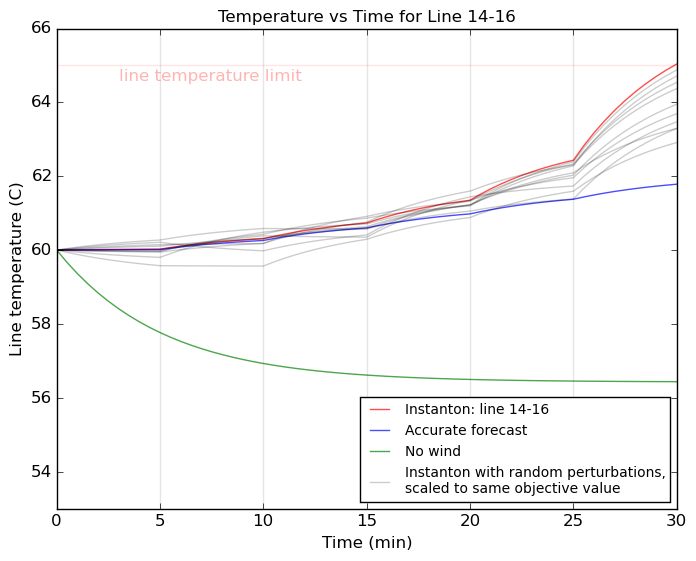

In [128]:
# Choose event index (1 is instanton):
eidx = 1

# System parameters:
n = length(k)
nr = length(Ridx)
T = int64(length(find(P0))/nr)

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 10
vecs = Array(Vector,0)

# First vector is instanton analysis output:
tempVec = Array(FloatingPoint,0)
for i in 1:T
    append!(tempVec,x[idx][i])
end
push!(vecs,tempVec)

# Second vector represents accurate forecast:
push!(vecs,zeros(length(vecs[1])))

# Third vector cancels all wind gen:
push!(vecs,-P0[find(P0)])

# Add a family of vectors with same norm as
# instanton vector:
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*(i+1)/35
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end

# Use power flow data and thermal model to compute
# temperature trajectories for each vector:
temp_trajectories = Array(Vector,0)
angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)
for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 60. #46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end
    push!(temp_trajectories,temp_values)
end

# Plot
fig = figure(figsize=(8,6))
xvals = (0:length(temp_trajectories[1])-1)*time_intervals*int_length/(60*(length(temp_trajectories[1])-1))
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(xvals,temp_trajectories[i],alpha=0.7,"r")
        elseif i == 2
        plot(xvals,temp_trajectories[i],alpha=0.7,"b")
        elseif i == 3
        plot(xvals,temp_trajectories[i],alpha=0.7,"g")
    else
        plot(xvals,temp_trajectories[i],alpha=0.2,"k")
    end
end
title("Temperature vs Time for Line $(from)-$(to)",fontsize=12)
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)",
    "Accurate forecast",    
    "No wind",
    "Instanton with random perturbations, \nscaled to same objective value"],fontsize=10,loc=4)
axis([0,30,53,66])
for i in 1:time_intervals
    xval = i*int_length/60
    plot([xval,xval],[40,1.1*Tlim],"k",alpha=0.1)
end
plot([0,30],[Tlim,Tlim],"r",alpha=0.1)
text(3,64.6,"line temperature limit",color="red",alpha=0.3)#color="#FFB2B2")

#savefig("../images/2015-06-24-trajectory_compare3.png", dpi=600)


## New idea: find each line's steady-state temperature assuming forecast is accurate

If any line is able to reach its temperature limit without deviation from forecast, we cannot perform instanton analysis. If we do, the result will be a wind pattern that causes an overall _reduction_ in temperature with respect to the steady-state temperature. The forecast (dispatch) must be altered until no line reaches its temperature limit.

Also, each instanton analysis run should have a steady-state temperature to begin with, based on the power flow across each line. This is something Mads does in his work. Currently, my analysis assumes all lines start at the same temperature, which is not realistic.

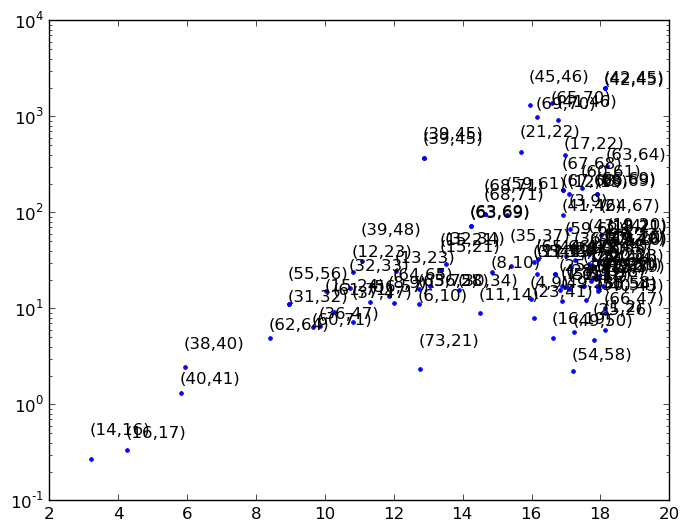

In [49]:
# System parameters:
n = length(k)
nr = length(Ridx)
T = int64(length(find(P0))/nr)

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.5
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Test vector represents no deviation from forecast:
testVec = zeros(Nr*T)

steady_angles = Array(Vector,0)
steady_diffs = Array(Vector,0)
temp_trajectories = Array(Vector,0)
for idx = 1:size(lines[line_lengths.!=0],1)
    # Line parameters:
    line = lines[line_lengths.!=0][idx]
    from,to = line
    r_ij = res[line_lengths.!=0][idx]
    x_ij = reac[line_lengths.!=0][idx]
    L_ij = line_lengths[line_lengths.!=0][idx]
    
    fixed_wind = testVec
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(steady_angles,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(steady_diffs,fixed_diffs)
    
    T0 = 60. #46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end

    push!(temp_trajectories,temp_values)
end

semilogy(65 - [v[end] for v in temp_trajectories],score,linewidth=0,marker=".")
labelStrings = [string(lines[line_lengths.!=0][idx]) for idx in 1:size(lines[line_lengths.!=0],1)]
for i in 1:length(temp_trajectories)
    annotate(labelStrings[i],(65 - temp_trajectories[i][end],score[i]),xytext=(0,20*rand()),textcoords="offset points")
end

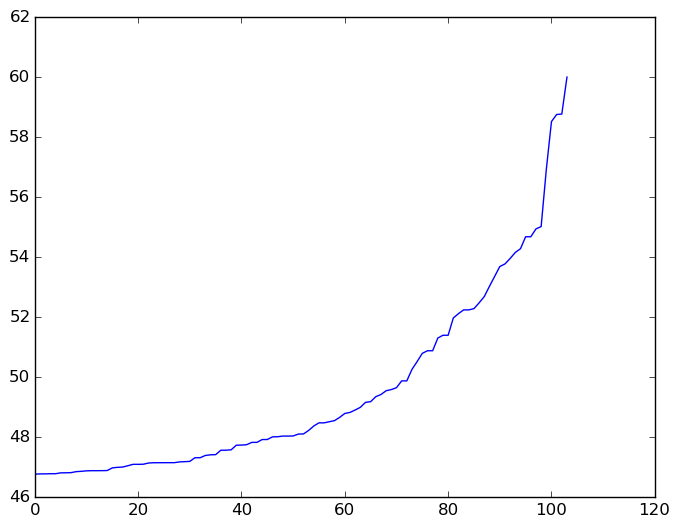

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f243b535590>

In [8]:
plot(sort([v[end] for v in temp_trajectories]))

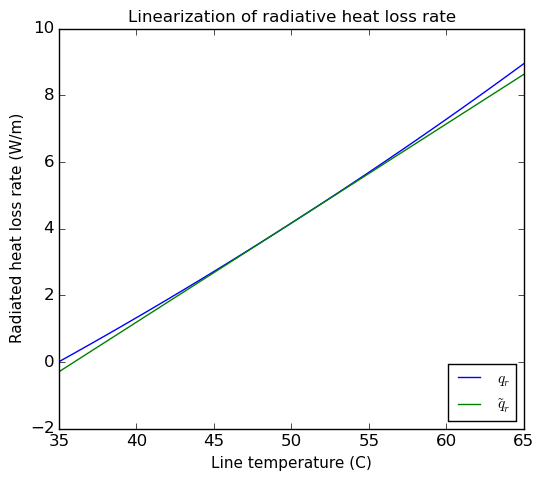

In [153]:
# Approximate radiative heat loss linearly.
# Linearize about the midpoint between ambient and limit temperatures.

rad_rate(T,Tamb,ηr) = ηr*((T+273).^4 - (Tamb+273).^4)

Tamb = 35. # C
Tlim = 65. # C
ηr = 2.207e-9 # W/m-C^4

function rad_rate_approx(T,Tamb,Tlim,ηr)
    Tmid = (Tamb + Tlim)/2
    return ηr*((Tmid + 273).^4 - (Tamb + 273).^4) + (4*ηr*(Tmid + 273).^3)*(T - Tmid)
end

fig = figure(figsize=(6,5))
Tmax = 65.
Trange = Tamb:1:Tmax
plot(Trange,rad_rate(Trange,Tamb,ηr))
xlabel("Line temperature (C)",fontsize=11)
ylabel("Radiated heat loss rate (W/m)",fontsize=11)
hold=true
plot(Trange,rad_rate_approx(Trange,Tamb,Tlim,ηr))
legend([L"q_r",L"\tilde{q}_r"],fontsize=11,loc=4)
title("Linearization of radiative heat loss rate",fontsize=12)
#savefig("../images/2015-06-24-rad_linear_approx.png",dpi=600)